In [20]:
# Run only for training!
import os
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
#import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.preprocessing import normalize
from classification_models.tfkeras import Classifiers
from tensorflow.python.keras.utils import losses_utils

# Change parameters here...
sizex = 500
sizey = 500
sizez = 3
rand_seed = 666
num_datasets = -1
batch_size = 32 * 4
nb_epochs = 400
validation_ratio = 0.2
#ds_size = len(data_dict['y_revs'])
ds_size = 405
buf_size = ds_size*2

architecture = 'custom'
resnet_select = 'resnet18'

dropout_active = False
dropout_rate = 0.1

use_dust = True

log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)
data_dir = 'data/'

if architecture =='alexnet':
    model_name = 'alexnet'  + '_aug'
elif architecture=='resnet':
    model_name = resnet_select + '_aug_constrain'
else:
    model_name = 'custom' + '_aug_2'
    
if dropout_active:
    model_name = model_name + '_bs'+str(batch_size)+'_drop'
else:
    model_name = model_name + '_bs'+str(batch_size)

if use_dust: model_name += '_dust'
        
snapshot_weights = 'models/'+model_name+'_best_weights_xy_gpu.hdf5'
last_snapshot_weights = 'models/'+model_name+'_last_weights_xy_gpu.hdf5'
json_name = 'models/'+model_name+'_model_xy_SGD_gpu.json'
trained_model = 'models/'+model_name+'_trained_xy_SGD_gpu.h5'

In [25]:
cossim = lambda y, p_y: -1*tf.keras.backend.abs(tf.keras.losses.cosine_similarity(y, p_y))
class myCosineSimilarity(tf.keras.losses.Loss):
    def __init__(self,
               axis=-1,
               reduction=losses_utils.ReductionV2.AUTO,
               name='myCosineSimilarity'):
        super(myCosineSimilarity, self).__init__(reduction=reduction, name=name)
        self._axis = axis
    
    def call(self, y_true, y_pred):
        cossim = lambda y, p_y: -1*tf.keras.backend.abs(tf.keras.losses.cosine_similarity(y, p_y, axis=self._axis))
        return cossim(y_true, y_pred)

strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Import the ResNet34 model
ResNet, preprocess_input = Classifiers.get(resnet_select)
with strategy.scope():
    # Build model
    if architecture == 'resnet':
        model = ResNet(input_shape=(sizex, sizey, sizez), include_top=False)
        
        for i in range(88, 29, -1):
            model._layers.pop()
            
        if dropout_active:
            dropout = tf.keras.layers.Dropout(dropout_rate)(model.layers[-1].output)
            globavg = tf.keras.layers.GlobalAveragePooling2D()(dropout)
        else:
            globavg = tf.keras.layers.GlobalAveragePooling2D()(model.layers[-1].output)
            
        output = tf.keras.layers.Dense(2, activation=None)(globavg)
        mymodel = tf.keras.models.Model(inputs=model.inputs, outputs=output)
        model = mymodel

    elif architecture == 'alexnet':
        
        model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(sizex,sizey,sizez)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')])
        
    elif architecture=='custom':
        model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=(sizex,sizey,sizez)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    # Use existing best weights if available...
    #if os.path.isfile(last_snapshot_weights):
    #    print('loaded weights')
    #    model.load_weights(last_snapshot_weights)

    model.compile(optimizer= tf.keras.optimizers.SGD(),
                  loss= myCosineSimilarity(), metrics=[cossim,
                                                                  tf.keras.losses.cosine_similarity,
                                                                  tf.keras.metrics.mean_absolute_error,])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Num GPUs Available:  0
Number of devices: 1


In [26]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 248, 248, 32)      2432      
_________________________________________________________________
batch_normalization_36 (Batc (None, 248, 248, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 246, 246, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 246, 246, 16)      528       
_________________________________________________________________
batch_normalization_37 (Batc (None, 246, 246, 16)      64        
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 246, 246, 32)      4640      
_________________________________________________________________
batch_normalization_38 (Batc (None, 246, 246, 32)     

In [27]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [5]:
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'y' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [6]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images) before filtering
data_dict['x_nodust'].shape

(895, 500, 500, 3)

In [7]:
#Filter the galaxies that have less than 1e10 solar masses
bad_ids = [[galaxy_id,i] for galaxy_id,i in zip(data_dict['ids'],range(len(data_dict['ids']))) if 'e09' in galaxy_id or 'e10' in galaxy_id ]
bad_ids = np.array(bad_ids)
remove_galaxies = np.array(bad_ids[:,1],dtype=int)
print('there are ', len(bad_ids), ' galaxies to remove')
#print(remove_galaxies)
filtered_dict = {}

for key in data_dict.keys():
    data_dict[key] = np.delete(data_dict[key],remove_galaxies, axis=0)
    
print('Still have ', len(data_dict['ids']), ' galaxies left')

there are  490  galaxies to remove
Still have  405  galaxies left


In [8]:
# check that we hace filtered the correct galaxies
data_dict['ids'][:5]

array(['g4.90e11_x134_y286_z196', 'g4.90e11_x26_y285_z64',
       'g4.90e11_x239_y101_z98', 'g4.90e11_x170_y94_z15',
       'g4.90e11_x147_y176_z286'], dtype='<U23')

In [9]:
# check the shape of the dictionary after filtering
data_dict['x_dust'].shape

(405, 500, 500, 3)

In [10]:
# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

#coming back the mapping from 1 to 180
def map_to_180(ang_norm):
  angle = ang_norm*180
  return angle

def random_flip_lr(image, label, seed=None):
    img = tf.image.random_flip_left_right(image, seed=seed)
    if tf.reduce_all(tf.equal(img,image)):
        label_f = label
    else:
        label_f = tf.convert_to_tensor([-label[0],label[1]])
    return (img, label_f)

def random_flip_ud(image, label, seed=None):
    img = tf.image.random_flip_up_down(image, seed=seed)
    if tf.reduce_all(tf.equal(img,image)):
        label_f = label
    else:
        label_f = tf.convert_to_tensor([label[0],-label[1]])
    return (img,label_f)

def augment(img, label):
    img_f,label_f = random_flip_lr(img,label)
    img_f,label_f = random_flip_ud(img_f,label_f)
    return (img_f, label_f)


# computing the normaliced vectors in 3D
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)

In [11]:
# check the shape of our dictionary in te labels entry
print(data_dict['y_norm'].shape)

(405, 3)


In [12]:
# separate in batches and shuffle the data with a fixed seed
AUTO = tf.data.experimental.AUTOTUNE

In [13]:
# functions to visualice the data 
def viz(img, label, pred=np.array([0,0,0]), id=None):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    ax.arrow(250,250,100*label[0],100*label[1], head_width=7, head_length=10, fc='g', ec='g')
    if np.sum(np.abs(pred)) > 0: ax.arrow(250,250,100*pred[0],100*pred[1], head_width=7, head_length=10, fc='r', ec='r')
        
    display(Markdown("#### **cartesian label:** {}".format(label)))
    if np.sum(np.abs(pred)) > 0: display(Markdown("#### **cartesian prediction (x_y):** {}".format(pred)))
    if id: display(Markdown("#### **ID:** {}".format(id)))
    plt.show()

#### **cartesian label:** [ 0.68517233 -0.33154832]

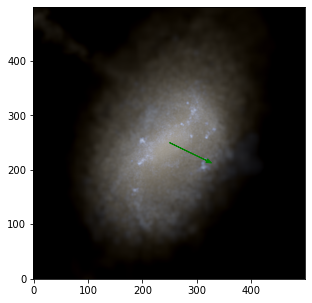

#### **cartesian label:** [ 0.68517233 -0.33154832]

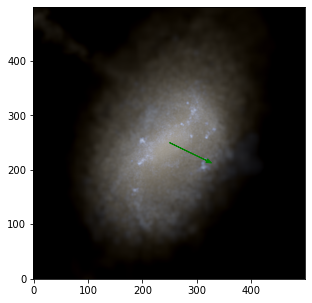

#### **cartesian label:** [-0.68517233 -0.33154832]

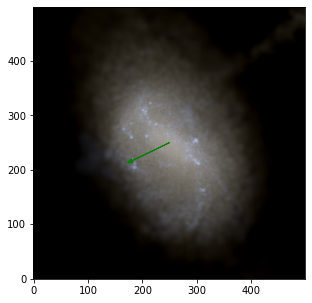

#### **cartesian label:** [-0.68517233  0.33154832 -0.64854806]

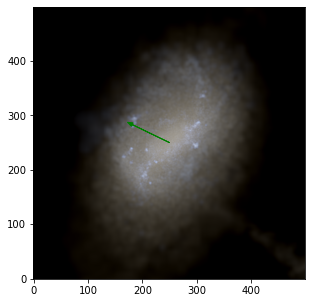

In [14]:
# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(10, seed=rand_seed)

# check the augmentation pipeline
index = np.random.randint(20)
for i in range(4):
    img, label = augment(data_dict['x_nodust'][index],data_dict['y_norm'][index])
    viz(img,label)

In [15]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
input_ds_nodust = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_norm'][:,:2].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))

input_ds_nodust = input_ds_nodust.take(ds_size)
val_size = math.floor(ds_size * validation_ratio)

#validation_ds = ( input_ds.take(val_size).batch(batch_size) )
#train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=buf_size, reshuffle_each_iteration=True).batch(batch_size) )

validation_ds_nodust_aug =  (input_ds_nodust.take(val_size))
train_ds_nodust_aug =  (input_ds_nodust.skip(val_size)
                        .map(augment, num_parallel_calls=AUTO))

if use_dust:
    input_ds_dust = (
        tf.data.Dataset.from_tensor_slices((data_dict['x_dust'].astype(np.float32), data_dict['y_norm'][:,:2].astype(np.float32)))
                        # Use seed to ensure we always have the same validation data set!
                       .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))

    input_ds_dust = input_ds_dust.take(ds_size)
    validation_ds_dust_aug = (input_ds_dust.take(val_size))
    train_ds_dust_aug =  (input_ds_dust.skip(val_size)
                            .map(augment, num_parallel_calls=AUTO))


    train_ds = (train_ds_dust_aug.concatenate(train_ds_nodust_aug)
                    .shuffle(buffer_size=buf_size, reshuffle_each_iteration=True)
                    .batch(batch_size).cache().prefetch(AUTO).repeat(2))
    validation_ds = (validation_ds_dust_aug.concatenate(validation_ds_nodust_aug)
                    .batch(batch_size).cache().prefetch(AUTO))
else:
                
    train_ds = (train_ds_nodust_aug
                    .shuffle(buffer_size=buf_size, reshuffle_each_iteration=True)
                    .batch(batch_size).cache().prefetch(AUTO).repeat(2))
    validation_ds = (validation_ds_nodust_aug
                    .batch(batch_size).cache().prefetch(AUTO))
            
print(validation_ds_nodust_aug)
print(train_ds_nodust_aug)

print(validation_ds)
print(train_ds)

<TakeDataset shapes: ((500, 500, 3), (2,)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((500, 500, 3), (2,)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<RepeatDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


#### **cartesian label:** [ 0.6136909 -0.6727376]

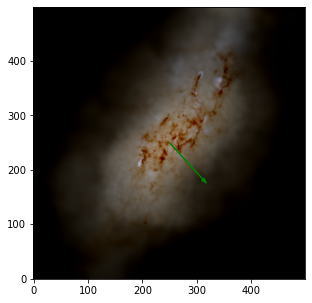

#### **cartesian label:** [-0.77296734 -0.36426532]

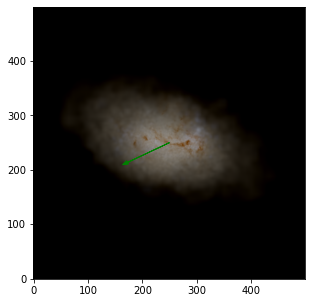

#### **cartesian label:** [ 0.32145023 -0.00480959]

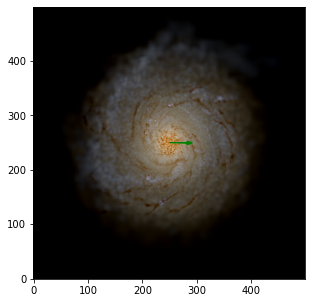

#### **cartesian label:** [ 0.6751578  -0.65628535]

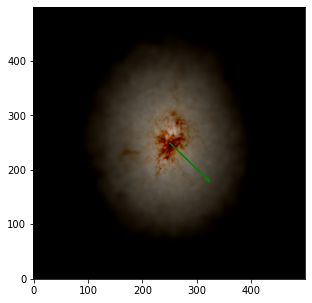

#### **cartesian label:** [0.5234982 0.630244 ]

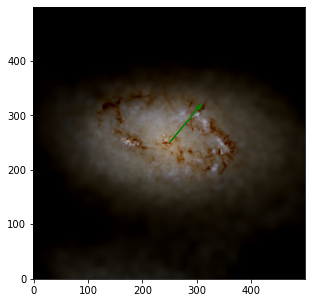

#### **cartesian label:** [-0.73368925  0.0586144 ]

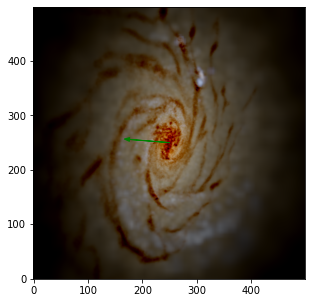

#### **cartesian label:** [0.8399979  0.30541787]

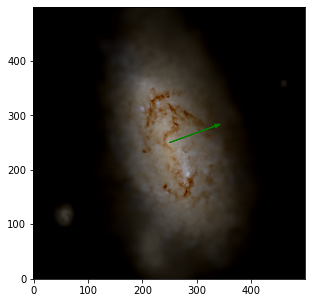

#### **cartesian label:** [0.87489325 0.48406422]

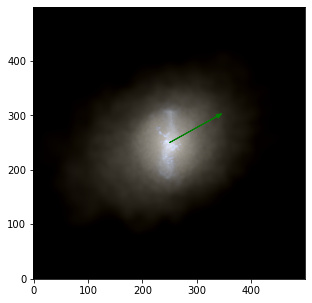

#### **cartesian label:** [-0.04052573  0.18351538]

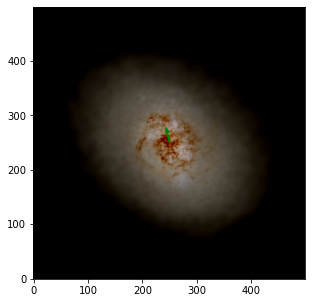

#### **cartesian label:** [-0.18464246  0.60754555]

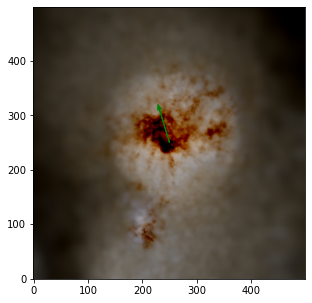

In [16]:
# create the dataset from the dictionary and see the size and type
#dataset = tf.data.Dataset.from_tensor_slices(data_dict)
#print(dataset)

# visualice the data
#real_dataset = dataset.batch(batch_size).shuffle(10, seed=rand_seed)
for idx in range(1,5):
    elements = train_ds.take(idx)
    for elem in elements:
        viz(elem[0][idx], elem[1][idx])#, elem['y_revs'][idx], id=elem['ids'][idx])

In [17]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

Reusing TensorBoard on port 6006 (pid 30439), started 0:13:45 ago. (Use '!kill 30439' to kill it.)

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open(json_name, "w") as json_file:
    json_file.write(model_json)

In [19]:
# model.summary()

# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer_1 = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)
checkpointer_2 = tf.keras.callbacks.ModelCheckpoint(filepath=last_snapshot_weights,
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=False)

#define the learning rate schedule
def scheduler(epoch, lr):
    return lr
    if epoch == 200:
        return lr / 100
    else:
        return lr

LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [
    tensorboard_callback,
    checkpointer_1,
    checkpointer_2,
    LearningRateScheduler
]

model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

Epoch 1/400
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Summary name batch_<lambda> is illegal; using batch__lambda_ instead.
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Summary name batch_<lambda> is illegal; using batch__lambda_ instead.
11/12 [==========================>...] - ETA: 8s - loss: -0.6400 - <lambda>: -0.6400 - cosine_similarity: -0.0232 - mean_absolute_error: 0.7252 INFO:tensorflow:Summary name epoch_<lambda> is illegal; using epoch__lambda_ instead.
INFO:tensorflow:Summary name epoch_<lambda> is illegal; using epoch__lambda_ instead.

Epoch 00001: val_loss improved from inf to -0.68798, saving model to models/alexnet_aug_bs128_dust_best_weights_xy_gpu.hdf5

Epoch 00001: saving model to models/alexnet_aug_bs128_dust_last_weights_xy_gpu.hdf5
12/12 [=============================

KeyboardInterrupt: 

In [ ]:
model.save(trained_model)

In [ ]:
model.load_weights(snapshot_weights)
print(snapshot_weights)

In [ ]:
# taking samples from the validation dataset and evaluating the model
val_ex, = validation_ds.take(1)
train_ex, = train_ds.take(1)
train_unbatch = train_ds.unbatch()

cos_los = myCosineSimilarity()
total_loss = 0
i = 0
for sample in train_unbatch:
    img,lab = sample
    lab = lab.numpy()
    img = tf.reshape(img,[-1,500,500,3])
    total_loss += cos_los(lab,model.predict(img))
    i += 1
    
total_loss = total_loss/i
print(total_loss)

images_v, labels_v = val_ex[0], val_ex[1]
images_t, labels_t = train_ex[0], train_ex[1]

outputs_v = model.predict(images_v)
outputs_t = model.predict(images_t)

In [ ]:
#print(labels_v[:5])
#print(outputs_v[:5])
print(cos_los(labels_v,outputs_v).numpy())
print(model.evaluate(validation_ds))


#print(labels_t[:5])
#print(outputs_t[:5])
print(cos_los(outputs_t,labels_t).numpy())
print(model.evaluate(train_ds))

In [ ]:
# visualicing the results
for img,label,pred,i in zip(images_t, labels_t, outputs_t,range(15)):
    viz(img, label, pred)

In [ ]:
for img,label,pred,i in zip(images_v, labels_v, outputs_v,range(15)):
    viz(img, label, pred)